## Load in data, preprocess and feature engineering 

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Load the data
train = pd.read_csv('training_imputed.csv')
test = pd.read_csv('testing_imputed.csv')

# Identify the target user WHO HAS THE MOST DATA
target_user = train['User ID'].value_counts().idxmax()
print("Target user:", target_user)

# Filter data for the target user
train_user = train[train['User ID'] == target_user].copy()
test_user = test[test['User ID'] == target_user].copy()

# Convert the Date/Time column to datetime and extract date
train_user['Date/Time'] = pd.to_datetime(train_user['Date/Time'])
test_user['Date/Time'] = pd.to_datetime(test_user['Date/Time'])

train_user['Date'] = train_user['Date/Time'].dt.date
test_user['Date'] = test_user['Date/Time'].dt.date

# Aggregate data by day for morning (start) and evening (end) entries
def aggregate_morning_evening(df):
    df = df.sort_values('Date/Time')
    if len(df) < 2:
        return None  # Skip days without both morning and evening entries
    morning = df.iloc[0]       # first record as morning features
    evening = df.iloc[-1]      # last record as target performance
    features = morning.copy()
    features['Evening_Performance'] = evening['Performance']
    return features

train_daily = train_user.groupby('Date').apply(aggregate_morning_evening).dropna().reset_index(drop=True)
test_daily = test_user.groupby('Date').apply(aggregate_morning_evening).dropna().reset_index(drop=True)

train_daily = train_daily.sort_values('Date').reset_index(drop=True)
test_daily = test_daily.sort_values('Date').reset_index(drop=True)

# Add previous day's evening performance as a feature (weighted lower)
weight_factor = 0.5  # Adjust weight as needed

# For training data:
train_daily['Prev_Evening_Performance'] = train_daily['Evening_Performance'].shift(1)
train_daily['Weighted_Prev_Evening'] = train_daily['Prev_Evening_Performance'] * weight_factor

# For testing data:
test_daily['Prev_Evening_Performance'] = test_daily['Evening_Performance'].shift(1)
test_daily['Weighted_Prev_Evening'] = test_daily['Prev_Evening_Performance'] * weight_factor

# Drop the first day since it doesn't have a previous evening value
train_daily = train_daily.dropna(subset=['Weighted_Prev_Evening']).reset_index(drop=True)
test_daily = test_daily.dropna(subset=['Weighted_Prev_Evening']).reset_index(drop=True)

train_daily['mood_score'] = (
    2 * train_daily['high_pos'] +
    1 * train_daily['low_pos'] -
    1 * train_daily['low_neg'] -
    2 * train_daily['high_neg']
)

test_daily['mood_score'] = (
    2 * test_daily['high_pos'] +
    1 * test_daily['low_pos'] -
    1 * test_daily['low_neg'] -
    2 * test_daily['high_neg']
)

# UNCOMMENT THIS TO INCLUDE A 3 DAY AVERAGE FOR MOOD
# train_daily['mood_3day_avg'] = train_daily['mood_score'].rolling(3).mean()
# test_daily['mood_3day_avg'] = test_daily['mood_score'].rolling(3).mean()


#  Create Delta_Performance feature
# Delta_Performance represents the change from the weighted previous evening performance to the current morning performance.
train_daily['Delta_Performance'] = train_daily['Performance'] - train_daily['Weighted_Prev_Evening']
test_daily['Delta_Performance'] = test_daily['Performance'] - test_daily['Weighted_Prev_Evening']

# Remove outliers based on the Evening_Performance target
def remove_target_outliers_iqr(df, target_col='Evening_Performance', multiplier=1.5):
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    filtered_df = df[(df[target_col] >= lower_bound) & (df[target_col] <= upper_bound)]
    return filtered_df.reset_index(drop=True)

# Apply to training and testing data
train_daily = remove_target_outliers_iqr(train_daily, target_col='Evening_Performance')
test_daily = remove_target_outliers_iqr(test_daily, target_col='Evening_Performance')

feature_mode = "momentum"


# Temporal Feature Augmentation
def add_lagged_features(df, n_lags=5, target_col='Evening_Performance'):
    for i in range(1, n_lags + 1):
        df[f'{target_col}_lag{i}'] = df[target_col].shift(i)
    return df

def add_rolling_stats(df, window=3, target_col='Evening_Performance'):
    df[f'{target_col}_roll_mean'] = df[target_col].shift(1).rolling(window=window).mean()
    df[f'{target_col}_roll_std'] = df[target_col].shift(1).rolling(window=window).std()
    return df

def add_momentum_features(df, target_col='Evening_Performance'):
    df['Delta1'] = df[target_col] - df[target_col].shift(1)
    df['Delta2'] = df[target_col].shift(1) - df[target_col].shift(2)
    df['Momentum'] = df['Delta1'] + df['Delta2']
    return df

# Apply features based on mode
if feature_mode == 'lagged':
    train_daily = add_lagged_features(train_daily)
    test_daily = add_lagged_features(test_daily)
elif feature_mode == 'rolling':
    train_daily = add_rolling_stats(train_daily)
    test_daily = add_rolling_stats(test_daily)
elif feature_mode == 'momentum':
    train_daily = add_momentum_features(train_daily)
    test_daily = add_momentum_features(test_daily)

# Drop rows with NaNs introduced by shifting/rolling
train_daily = train_daily.dropna().reset_index(drop=True)
test_daily = test_daily.dropna().reset_index(drop=True)




# Drop the raw weighted previous evening feature.
train_daily = train_daily.drop(columns=['Weighted_Prev_Evening'], errors='ignore')
test_daily = test_daily.drop(columns=['Weighted_Prev_Evening'], errors='ignore')

# UNCOMMENT TO INCLUDE DAYS OF WEEK AND CYCLICAL DATA
# train_daily['DayOfWeek'] = train_user['Date/Time'].dt.dayofweek
# test_daily['DayOfWeek'] = test_user['Date/Time'].dt.dayofweek

# train_daily['DayOfWeek_sin'] = np.sin(2 * np.pi * train_daily['DayOfWeek'] / 7)
# test_daily['DayOfWeek_sin'] = np.sin(2 * np.pi * test_daily['DayOfWeek'] / 7)

train_daily['HRV_x_Sleep'] = train_daily['HRV']*train_daily['Sleep']
test_daily['HRV_x_Sleep'] = test_daily['HRV']*test_daily['Sleep']



# UNCOMMENT TO INCLUDE A BANDED SLEEP HEART RATE
# train_daily['Sleep_HR'] = pd.qcut(train_daily['Sleep Heart Rate'], q=3, labels=['Low', 'Med', 'High'])
# test_daily['Sleep_HR'] = pd.qcut(test_daily['Sleep Heart Rate'], q=3, labels=['Low', 'Med', 'High'])

# # One-hot encode or use LabelEncoder
# train_daily = pd.get_dummies(train_daily, columns=['Sleep_HR'])
# test_daily = pd.get_dummies(test_daily, columns=['Sleep_HR'])
# # Ensure test set has the same dummy columns as train
# train_daily, test_daily = train_daily.align(test_daily, join='left', axis=1, fill_value=0)


# Prepare features and target for the model by explicitly dropping unwanted columns
drop_cols = ['Date', 'Date/Time', 'User ID', 'Prev_Evening_Performance']
train_daily = train_daily.drop(columns=drop_cols, errors='ignore')
test_daily = test_daily.drop(columns=drop_cols, errors='ignore')

# Select only numeric columns as features.
numeric_cols = train_daily.select_dtypes(include=['number']).columns.tolist()
if 'Evening_Performance' in numeric_cols:
    numeric_cols.remove('Evening_Performance')
feature_cols = numeric_cols


X_train = train_daily[feature_cols]
y_train = train_daily['Evening_Performance']
X_test = test_daily[feature_cols]
y_test = test_daily['Evening_Performance']

print("\nSelected feature columns:")
print(feature_cols)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Target user: sMGdHxYjhvTCGsGO6T39nPOu1Yk2


/var/folders/bc/3d9zy0_13wvgh2zl4n2kwn0r0000gp/T/ipykernel_68886/2513338960.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_daily = train_user.groupby('Date').apply(aggregate_morning_evening).dropna().reset_index(drop=True)



Selected feature columns:
['Age', 'Sleep', 'HRV', 'Sleep Heart Rate', 'high_pos', 'low_pos', 'high_neg', 'low_neg', 'Neutral', 'Steps', 'Tiredness', 'Calm', 'Nutrition', 'Hydration', 'Performance', 'Gender_encode', 'mood_score', 'Delta_Performance', 'Delta1', 'Delta2', 'Momentum', 'HRV_x_Sleep']


/var/folders/bc/3d9zy0_13wvgh2zl4n2kwn0r0000gp/T/ipykernel_68886/2513338960.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_daily = test_user.groupby('Date').apply(aggregate_morning_evening).dropna().reset_index(drop=True)


## Grid seach XGBoost

In [2]:

# Setup Grid Search for XGBoost
param_grid = {
    'n_estimators': [75, 90, 105],
    'max_depth': [4,5,6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6,0.7, 0.8],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [ 0.05, 0.1, 0.15],
    'reg_lambda': [0.5,1.0 ]
}

# UNCOMMENT THIS TO ONLY TRAIN BEST MODEL 
# xgb_model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     random_state=42,
#     colsample_bytree=1.0,
#     learning_rate=0.1,
#     max_depth=5,
#     n_estimators=105,
#     reg_alpha=0.1,
#     reg_lambda=0.5,
#     subsample=0.7
# )
# xgb_model.fit(X_train_scaled, y_train)
# xgb_preds = xgb_model.predict(X_test_scaled)
# test_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
# print("\nTest RMSE:", test_rmse)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Perform grid search on the training data.
grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest cross-validation RMSE:")
print(-grid_search.best_score_)  # scoring returns negative RMSE

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_preds = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print("\nTest RMSE:", test_rmse)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Best parameters found:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 105, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.7}

Best cross-validation RMSE:
4.526689902203602

Test RMSE: 3.941912303735413


## Plot feature importances

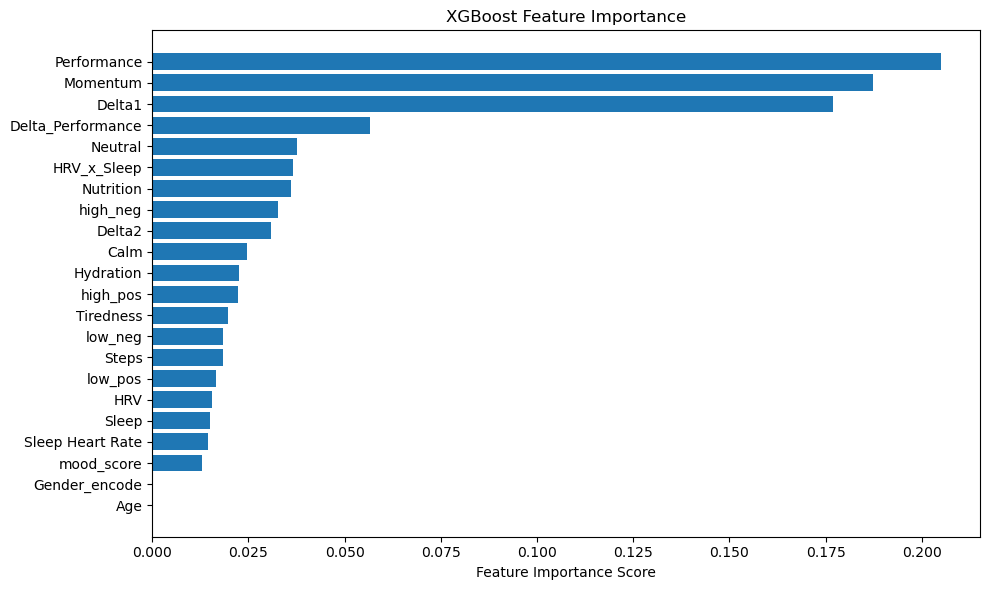

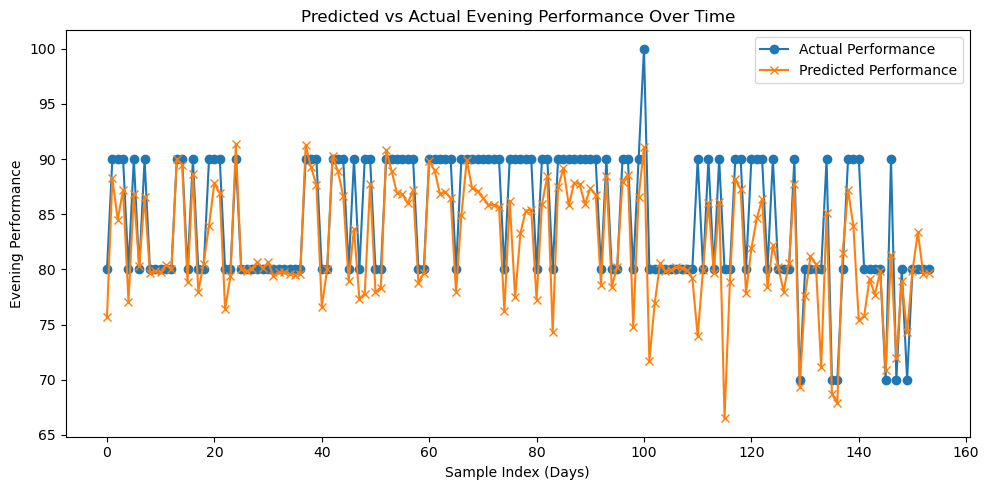


Evaluation Metrics:
Test RMSE: 3.9419
Test MAE : 2.6823
Test R²  : 0.5414

Top Features by Importance:
              Feature  Importance
14        Performance    0.204868
20           Momentum    0.187329
18             Delta1    0.176931
17  Delta_Performance    0.056719
8             Neutral    0.037528
21        HRV_x_Sleep    0.036655
12          Nutrition    0.036108
6            high_neg    0.032767
19             Delta2    0.030889
11               Calm    0.024714
13          Hydration    0.022430
4            high_pos    0.022214
10          Tiredness    0.019612
7             low_neg    0.018407
9               Steps    0.018373
5             low_pos    0.016519
2                 HRV    0.015433
1               Sleep    0.014988
3    Sleep Heart Rate    0.014595
16         mood_score    0.012922
15      Gender_encode    0.000000
0                 Age    0.000000


In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Feature Importance Plot
importances = best_model.feature_importances_
sorted_idx = np.argsort(importances)
sorted_features = [feature_cols[i] for i in sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_idx])
plt.yticks(range(len(importances)), sorted_features)
plt.xlabel('Feature Importance Score')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Predictions vs Actual Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Performance', marker='o')
plt.plot(test_preds, label='Predicted Performance', marker='x')
plt.title('Predicted vs Actual Evening Performance Over Time')
plt.xlabel('Sample Index (Days)')
plt.ylabel('Evening Performance')
plt.legend()
plt.tight_layout()
plt.show()

# Print Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, test_preds))
mae = mean_absolute_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)

print("\nEvaluation Metrics:")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test R²  : {r2:.4f}")

# Optionally, print feature importances with names
feature_scores = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(feature_scores)


## Train MLP Regressor

In [4]:
from sklearn.neural_network import MLPRegressor






param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
}

mlp = MLPRegressor(
    activation='relu',
    solver='adam',
    max_iter=1000,
    early_stopping=True,
    random_state=42
)

grid_search = GridSearchCV(mlp, param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best MLP parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

# Evaluate best model
best_mlp = grid_search.best_estimator_
mlp_preds = best_mlp.predict(X_test_scaled)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, mlp_preds)))
print("Test R²:", r2_score(y_test, mlp_preds))


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/u1604360/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/u1604360/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/u1604360/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/u1604360/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/u

/Users/u1604360/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/u1604360/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/u1604360/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/u1604360/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/u

Best MLP parameters: {'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}
Best CV RMSE: 3.881576749560806
Test RMSE: 3.033135589074824
Test R²: 0.7284904166567838


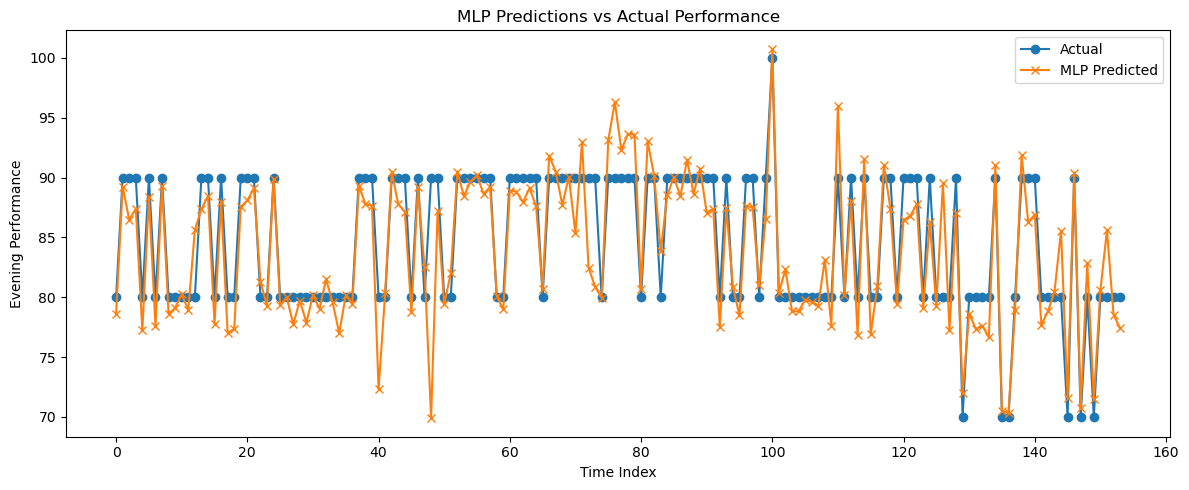

In [5]:
# Predict
mlp_preds = best_mlp.predict(X_test_scaled)

# Plot over time (or index)
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Actual", marker='o')
plt.plot(mlp_preds, label="MLP Predicted", marker='x')
plt.title("MLP Predictions vs Actual Performance")
plt.xlabel("Time Index")
plt.ylabel("Evening Performance")
plt.legend()
plt.tight_layout()
plt.show()


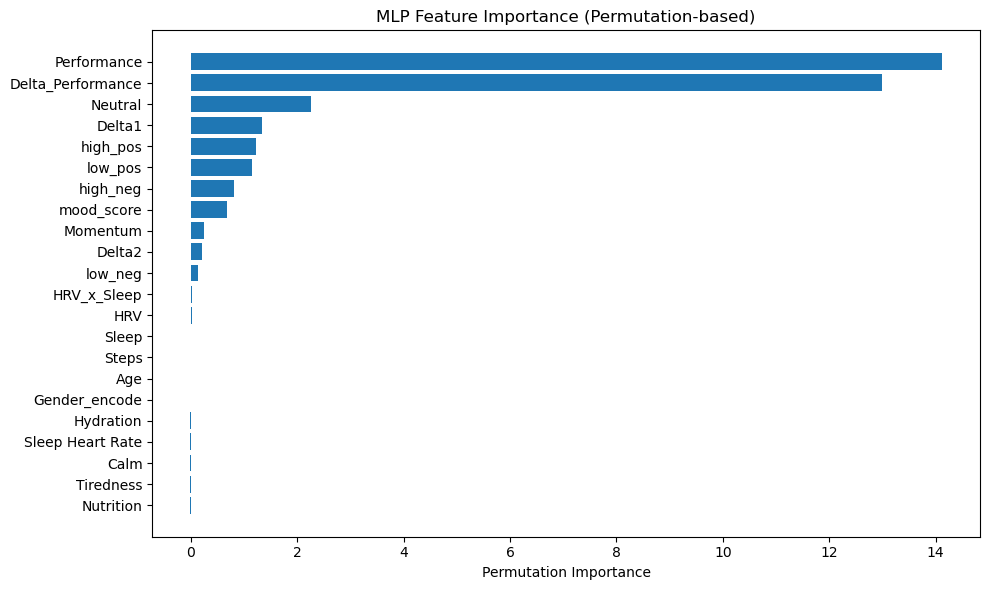

In [6]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Use your trained MLP model
result = permutation_importance(best_mlp, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Sort by importance
sorted_idx = result.importances_mean.argsort()[::-1]
importances = result.importances_mean[sorted_idx]
feature_names_sorted = [feature_cols[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names_sorted, importances)
plt.xlabel("Permutation Importance")
plt.title("MLP Feature Importance (Permutation-based)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Create ensemble method

Ensemble RMSE: 2.6760
Ensemble R²:   0.7887


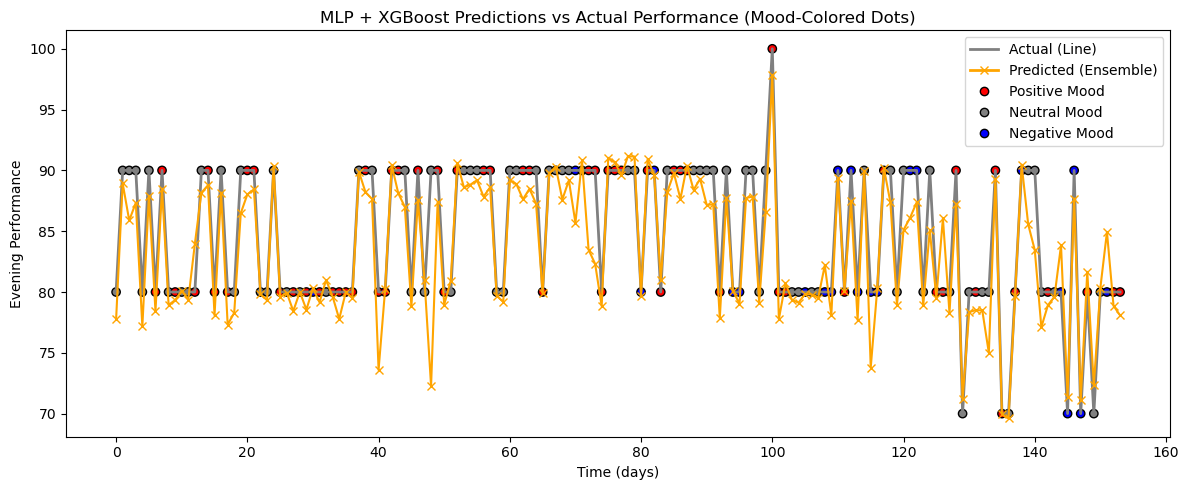

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np

# Combine predictions
gb_weight = 0.3
comb_preds = gb_weight * test_preds + (1 - gb_weight) * mlp_preds
comb_rmse = np.sqrt(mean_squared_error(y_test, comb_preds))
comb_r2 = r2_score(y_test, comb_preds)

print(f"Ensemble RMSE: {comb_rmse:.4f}")
print(f"Ensemble R²:   {comb_r2:.4f}")

# Map mood scores to fixed colors
mood_score = test_daily['mood_score'].values
mood_colors = np.where(mood_score > 0, 'red', np.where(mood_score < 0, 'blue', 'grey'))

# Plot
plt.figure(figsize=(12, 5))

# Actual (grey line)
plt.plot(y_test.values, color='grey', linewidth=2)

# Mood-colored dots (actual points)
plt.scatter(range(len(y_test)), y_test.values, c=mood_colors, edgecolors='black')

# Predicted (orange line)
plt.plot(comb_preds, color='orange', marker='x')

# Legend elements
legend_elements = [
    Line2D([0], [0], color='grey', lw=2, label='Actual (Line)'),
    Line2D([0], [0], color='orange', marker='x', label='Predicted (Ensemble)', lw=2),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Positive Mood', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', label='Neutral Mood', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='Negative Mood', markeredgecolor='black')
]

# Apply legend
plt.legend(handles=legend_elements)

# Final styling
plt.title("MLP + XGBoost Predictions vs Actual Performance (Mood-Colored Dots)")
plt.xlabel("Time (days)")
plt.ylabel("Evening Performance")
plt.tight_layout()
plt.show()
